# Conv NN

<ol>1. Loading the dataset</ol>
<ol>2. Pre-processing the data</ol>
<ol>3. Creating training and validation set</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Compiling the model</ol>
<ol>6. Training the model</ol>
<ol>7. Evaluating model performance</ol>

In [1]:
import tensorflow as tf
import keras
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)

tensorflow version:  2.9.2
keras version:  2.9.0


In [2]:
# define sess to use gpu
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P4000, pci bus id: 0000:00:05.0, compute capability: 6.1



In [3]:
# import necessary libraries and functions
import os
import joblib
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense, InputLayer
from keras.models import Sequential

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
import sys

sys.path.append('..')
from utils.s3_class import S3Functions
s3_funcs = S3Functions(bucket_name='jdgallegoq-pinacle')

In [5]:
# create random number generator
seed = 42
rng = np.random.RandomState(seed)

In [6]:
# train data
train_data = pd.read_csv(s3_funcs.read_object(key='gender_clf/train/train.csv'))
print(train_data.info())

# test data
test_data = pd.read_csv(s3_funcs.read_object(key='gender_clf/test.csv'))
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12196 entries, 0 to 12195
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  12196 non-null  object
 1   class        12196 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 190.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  5227 non-null   object
dtypes: object(1)
memory usage: 41.0+ KB
None


In [7]:
train_data['class'].value_counts()

1    6174
0    6022
Name: class, dtype: int64

In [8]:
# load images
IMAGES_PATH = 'gender_clf/train/images/'

X = []
not_found = []
num_images_read = 5000
#for img_name in tqdm(train_data.image_names):
for img_name in tqdm(train_data.image_names[:num_images_read]):
  img = s3_funcs.read_image(key=IMAGES_PATH+img_name)
  X.append(img)

X = np.array(X)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
# preprocess scaing pixels
X = X / X.max()

In [10]:
# split dataset
y = train_data['class'].values[:num_images_read]
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

del X

In [12]:
# Model architecture
#from tensorflow.keras.preprocessing.image import ImageGenerator
from keras.layers import (
    InputLayer,
    Dense,
    Dropout,
    BatchNormalization,
    Flatten,
    Conv2D,
    MaxPool2D
    )
from keras.models import Sequential
from keras.optimizers import Adam

In [14]:
model = Sequential()
# X train has 3 channels so features are pixels per channel
model.add(InputLayer(input_shape=X_train.shape[1:]))
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
# add maxpools after conv layers
model.add(MaxPool2D(pool_size=(4, 4), padding='valid'))
model.add(Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(MaxPool2D(pool_size=(4, 4), padding='valid'))
model.add(Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='valid'))
model.add(MaxPool2D(pool_size=(4, 4), padding='valid'))
# flatten so it can be passed to a dense layer
model.add(Flatten())
# add dense layers
model.add(Dense(units=100, activation='sigmoid'))
# dropout to avoid overfitting
model.add(Dropout(rate=0.6))
# add batch normalization to maintain vector values normalized
model.add(BatchNormalization())
model.add(Dense(units=100, activation='sigmoid'))
model.add(Dropout(rate=0.6))
model.add(BatchNormalization())
# final layer
model.add(Dense(units=1, activation='sigmoid'))

# print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 25)      1900      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 25)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 51, 50)        31300     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 50)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 50)          62550     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 50)        

In [15]:
# compile
adam = Adam(learning_rate=1e-5, clipvalue=1)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [16]:
# train
epochs = 10
batch_size = 128
model_history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_valid, y_valid)
)

2024-04-11 22:57:45.101458: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.
2024-04-11 22:57:48.311093: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.


Epoch 1/10
32/32 [==============================] - 16s 209ms/step - loss: 0.9307 - accuracy: 0.5035 - val_loss: 0.8202 - val_accuracy: 0.4930
Epoch 2/10
32/32 [==============================] - 4s 136ms/step - loss: 0.9230 - accuracy: 0.4845 - val_loss: 0.7738 - val_accuracy: 0.4930
Epoch 3/10
32/32 [==============================] - 4s 136ms/step - loss: 0.9087 - accuracy: 0.5023 - val_loss: 0.7401 - val_accuracy: 0.4930
Epoch 4/10
32/32 [==============================] - 4s 133ms/step - loss: 0.8930 - accuracy: 0.5088 - val_loss: 0.7189 - val_accuracy: 0.4930
Epoch 5/10
32/32 [==============================] - 4s 135ms/step - loss: 0.9153 - accuracy: 0.4940 - val_loss: 0.7058 - val_accuracy: 0.4930
Epoch 6/10
32/32 [==============================] - 4s 134ms/step - loss: 0.9076 - accuracy: 0.5020 - val_loss: 0.6984 - val_accuracy: 0.4930
Epoch 7/10
32/32 [==============================] - 4s 135ms/step - loss: 0.9145 - accuracy: 0.5110 - val_loss: 0.6931 - val_accuracy: 0.4930
Epoch

In [18]:
# evaluate
train_classes = (model.predict(X_train) > 0.5).astype('float32')
print('Acc on train: ', accuracy_score(y_train, train_classes))

val_classes = (model.predict(X_valid) > 0.5).astype('float32')
print('Acc on val: ', accuracy_score(y_valid, val_classes))

2024-04-11 23:01:04.705270: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.
2024-04-11 23:01:07.725109: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.


125/125 [==============================] - 3s 17ms/step
Acc on train:  0.57425
32/32 [==============================] - 1s 18ms/step
Acc on val:  0.573


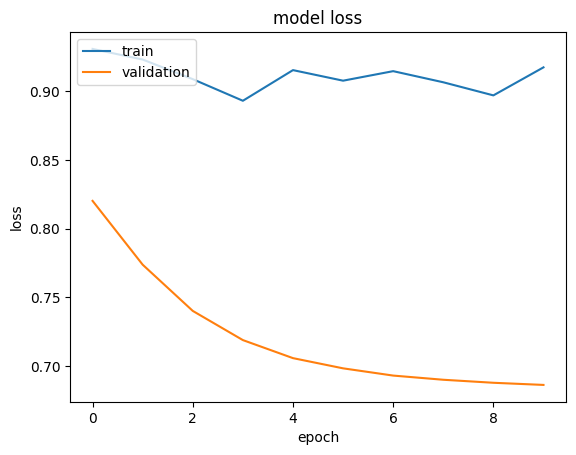

In [19]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='upper left')
plt.show()